<a href="https://colab.research.google.com/github/cmisra/RaagBase/blob/main/Musical_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Necessary Packages**

In [ ]:
from functools import reduce
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as louvain
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
import math
import itertools
import statistics
from numpy import random
import matplotlib.pyplot as plt


# **Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Reading Bhatkhande Dataset**

In [ ]:
import pandas as pd
# df=pd.read_csv("/content/drive/MyDrive/My Research/Graph Representation of Music/Bhatkhande-Dataset.csv")
df=pd.read_csv("/content/drive/MyDrive/My Research/Graph Representation of Music/Copy of Bhatkhande-Dataset.csv")
df

,s,R,r,G,g,m,M,p,D,d,N,n,Raag
0,1,12,0,0,21,15,0,8,15,0,0,14,Bhairav
1,29,18,0,0,22,23,0,11,8,0,0,16,Bhairav
2,26,8,0,0,21,17,0,19,27,0,1,20,Bhairav
3,28,10,0,0,13,19,0,11,21,0,0,22,Bhairav
4,19,8,0,0,0,15,0,10,14,0,2,11,Bhairav
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,17,20,0,11,0,0,11,1,18,0,1,8,Todi
112,18,14,0,12,0,0,14,13,19,0,0,9,Todi
113,13,11,0,16,0,0,16,9,19,0,0,8,Todi
114,15,11,0,9,0,0,9,5,17,0,0,17,Todi


# **Creating the Ground Truth as a Dictionary**
*Keys represents the sample id and values represents the raag the sample composition belongs to. There are 3 raags (Bhairav, Poorvi, and Todi) which are represented as 0, 1, and 2.*



In [ ]:
raag = {'Bhairav':0, 'Poorvi':1, 'Todi':2}
str_arr = df['Raag'].values.astype('U')
# ground_truth = [raag[i] for i in str_arr]
comp_id = [i for i in range(0,116)]
label = [raag[i] for i in str_arr]
ground_truth = dict(zip(comp_id, label))
ground_truth

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 2,
 78: 2,
 79: 2,
 80: 2,
 81: 2,
 82: 2,
 83: 2,
 84: 2,
 85: 2,
 86: 2,
 87: 2,
 88: 2,
 89: 2,
 90: 2,
 91: 2,
 92: 2,
 93: 2,
 94: 2,
 95: 2,
 96: 2,
 97: 2,
 98: 2,
 99: 2,
 100: 2,
 101: 2,
 102: 2,
 103: 2,
 104: 2,
 105: 2,
 106: 2,
 107: 2,
 108: 2,
 109: 2,
 110: 2,
 111: 2,
 112: 2,
 113: 2,
 114: 2,
 115: 2}

# **Python Method for calculating the cosine similarity between two compositions**

*The cos_simi_raag method calculates the cosine similarity between every composition to every other composition in the dataset. The method then filters out the cosine similarity values that are equal to 0 (same compositions) and > some threshold cosine similarity value.*

In [ ]:
def cos_simi_raag(dataframe, threshold):

  with open('/content/drive/MyDrive/My Research/Graph Representation of Music/readme-cos-'+str(threshold)+'.txt', 'w') as f:
  # with open('/content/drive/MyDrive/My Research/Graph Representation of Music/readme.txt', 'w') as f:

    ids_dataframe = dataframe.index.values

    cos_sim_list=[]
    cosine_sim_list_all=[]
    for id_d1 in ids_dataframe:
      cosine_max=0
      for id_d2 in ids_dataframe:
        a = dataframe.iloc[id_d1, 0:12]
        a = a/np.sum(a)
        b = dataframe.iloc[id_d2, 0:12]
        b = b/np.sum(b)
        sum = reduce(lambda a, b: a + b, map(lambda a, b: a * b, a, b))
        a_square = math.sqrt(reduce(lambda a, b: a + b, map(lambda a: a * a, a)))
        b_square = math.sqrt(reduce(lambda a, b: a + b, map(lambda b: b * b, b)))
        cosine_sim = sum / (a_square * b_square)




      #   if cosine_sim == 0:
      #     print(id_d1)
      #     print(id_d2)
      #     cosine_sum = cosine_sum + cosine_sim
      # cos_sim_list.append(cosine_sum / len(ids_dataframe))

        if (cosine_sim > threshold) & (id_d1 != id_d2):
            if (cosine_max < cosine_sim):
              cosine_max = cosine_sim
            cosine_sim_list_all.append(cosine_sim)
            #print(id_d1)
            #print(id_d2)
            #print(cosine_sim)

            f.write(str(id_d1))
            f.write('\t')
            f.write(str(id_d2))
            f.write('\t')
            f.write(str(cosine_sim))
            f.write('\n')
            # print(cosine_sim)
      # print(cosine_max)
  f.close()

  return cosine_sim_list_all

# **Python Method for calculating the Euclidean Distance between two compositions**

*The euclidean method calculates the Euclidean Distance between every composition to every other composition in the dataset. The method then filters out the distance values that coming from same compositions and < some threshold distance value. The sample values are normalized before caluculating the distance between them*

In [ ]:
def euclidean(dataframe, threshold):

  with open('/content/drive/MyDrive/My Research/Graph Representation of Music/readme-eud-'+str(threshold)+'.txt', 'w') as f:
  # with open('/content/drive/MyDrive/My Research/Graph Representation of Music/readme.txt', 'w') as f:

    ids_dataframe = dataframe.index.values

    eud_dist_list_all=[]
    for id_d1 in ids_dataframe:
      for id_d2 in ids_dataframe:
        a = dataframe.iloc[id_d1, 0:12]
        a = a/np.sum(a)
        b = dataframe.iloc[id_d2, 0:12]
        b = b/np.sum(b)

        eud_dist = math.sqrt(reduce(lambda a, b: a + b, map(lambda a, b: (a - b) ** 2, a, b)))


        if (eud_dist < threshold) & (id_d1 != id_d2):

            eud_dist_list_all.append(eud_dist)


            f.write(str(id_d1))
            f.write('\t')
            f.write(str(id_d2))
            f.write('\t')
            f.write(str(eud_dist))
            f.write('\n')

  f.close()

  return eud_dist_list_all

# **Number of pair of samples having cosine similarity above threshold value**

In [ ]:
#cos
np_array = np.array(cos_simi_raag(df,0.92))
print(np_array.size / 2)

3198

In [ ]:
#eud
np_array = np.array(euclidean(df, 0.08))
np_array.size

534

In [ ]:
#cos
new_arr = np_array[np_array > 0.92]
new_arr.size

3198

In [ ]:
#eud
new_arr = np_array[np_array < 0.08]
new_arr.size

534

# **Creating the graph from the edgelist**

In [ ]:
# cosine
threshold=0.92
g = nx.read_edgelist('/content/drive/MyDrive/My Research/Graph Representation of Music/readme-cos-'+str(threshold)+'.txt', nodetype=int, data=(('weight',float),), create_using= nx.Graph())
# g = nx.read_edgelist('/content/drive/MyDrive/My Research/Graph Representation of Music/readme.txt', nodetype=int, data=(('weight',float),), create_using= nx.Graph())

In [ ]:
#euclidean distance
threshold=0.08
g = nx.read_edgelist('/content/drive/MyDrive/My Research/Graph Representation of Music/readme-eud-'+str(threshold)+'.txt', nodetype=int, data=(('weight',float),), create_using= nx.Graph())
# g = nx.read_edgelist('/content/drive/MyDrive/My Research/Graph Representation of Music/readme.txt', nodetype=int, data=(('weight',float),), create_using= nx.Graph())

# **Printing the edges with the cosine similarity score**

In [ ]:
print(g.edges(data=True))

[(1, 3, {'weight': 0.9281966215711505}), (1, 6, {'weight': 0.9249603265224292}), (1, 7, {'weight': 0.9313326686597072}), (1, 10, {'weight': 0.9535173684267625}), (1, 11, {'weight': 0.9364852278074061}), (1, 12, {'weight': 0.9794113699955943}), (1, 13, {'weight': 0.9531367051672757}), (1, 14, {'weight': 0.9323967295352591}), (1, 16, {'weight': 0.9629252689998722}), (1, 17, {'weight': 0.9804334763843574}), (1, 19, {'weight': 0.9604322918188726}), (1, 21, {'weight': 0.9734134729776307}), (1, 22, {'weight': 0.9332467654835386}), (1, 23, {'weight': 0.9586501840668343}), (1, 27, {'weight': 0.975961974988046}), (1, 28, {'weight': 0.975961974988046}), (1, 30, {'weight': 0.9546479710200649}), (1, 31, {'weight': 0.9335065711972272}), (1, 32, {'weight': 0.9293630117792808}), (1, 33, {'weight': 0.9786130208166174}), (1, 34, {'weight': 0.9400863864092969}), (1, 35, {'weight': 0.9624641244418541}), (1, 36, {'weight': 0.9656648545542428}), (1, 38, {'weight': 0.9454603416723001}), (3, 2, {'weight': 0.

In [ ]:
print(sorted(g.nodes()))
print(g.number_of_nodes())
print(g.number_of_edges())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
115
1599


# **Plotting the graph generated from cosine similarity**

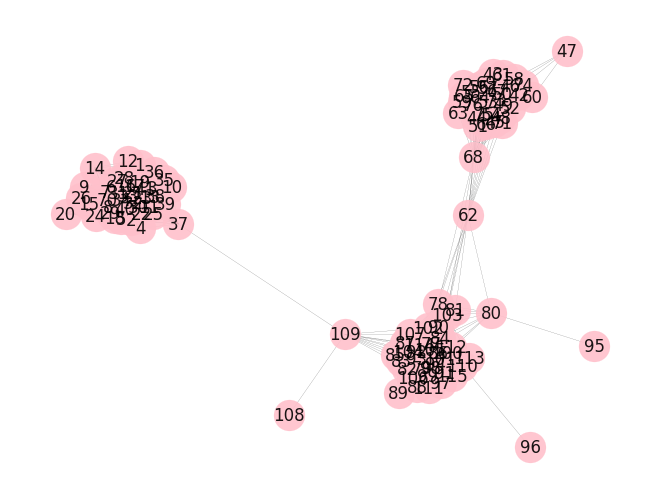

In [ ]:
pos = nx.spring_layout(g)
# pos = nx.kamada_kawai_layout(g)
# pos = nx.fruchterman_reingold_layout(g)
nx.draw(
    g, pos, edge_color='black', width=0.1, linewidths=0.11,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in g.nodes()}
)

plt.show()

# **Applying Louvain clustering algorithm on the graph and checking the number of communities**

In [ ]:
cmty_louvn=nx.community.louvain_communities(g)
print(len(cmty_louvn))

7


# **Calculating the cluster performance score using NMI and ARS**

In [ ]:
predicted_cmty_label = {}
for i in cmty_louvn[0]:
  predicted_cmty_label[i] = 0
for i in cmty_louvn[1]:
  predicted_cmty_label[i] = 1
for i in cmty_louvn[2]:
  predicted_cmty_label[i] = 2
for i in cmty_louvn[3]:
  predicted_cmty_label[i] = 3
for i in cmty_louvn[4]:
  predicted_cmty_label[i] = 4
for i in cmty_louvn[5]:
  predicted_cmty_label[i] = 5
for i in cmty_louvn[6]:
  predicted_cmty_label[i] = 6
# for i in cmty_louvn[7]:
#   predicted_cmty_label[i] = 7

print(predicted_cmty_label)

list_data = []
for i in predicted_cmty_label.keys():
  # print(predicted_cmty_label.get(i))
  list_data.append(predicted_cmty_label.get(i))

print(len(list_data))
label_predicted = np.array(list_data)
print(label_predicted)

predicted_keys = predicted_cmty_label.keys()
predicted_list = list(predicted_keys)
predicted_list.sort()
# print(predicted_list)

filtered_truth = [ground_truth.get(i) for i in predicted_list]
print(len(filtered_truth))
label_ground = np.array(filtered_truth)
print(label_ground)

print(normalized_mutual_info_score(label_ground, label_predicted))
print(adjusted_rand_score(label_ground, label_predicted))

{1: 0, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 11: 0, 13: 0, 16: 0, 17: 0, 18: 0, 19: 0, 21: 0, 22: 0, 23: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 70: 0, 10: 1, 35: 1, 66: 2, 55: 2, 71: 2, 57: 2, 59: 2, 63: 2, 64: 3, 65: 3, 67: 3, 69: 3, 72: 3, 73: 3, 75: 3, 76: 3, 42: 3, 43: 3, 44: 3, 45: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 3, 56: 3, 74: 4, 46: 4, 98: 5, 100: 5, 101: 5, 103: 5, 105: 5, 77: 5, 110: 5, 79: 5, 112: 5, 113: 5, 115: 5, 84: 5, 86: 5, 91: 5, 94: 5, 99: 6, 102: 6, 104: 6, 106: 6, 111: 6, 82: 6, 83: 6, 114: 6, 85: 6, 87: 6, 88: 6, 89: 6, 92: 6, 93: 6}
91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2

# **Plot the clusters**

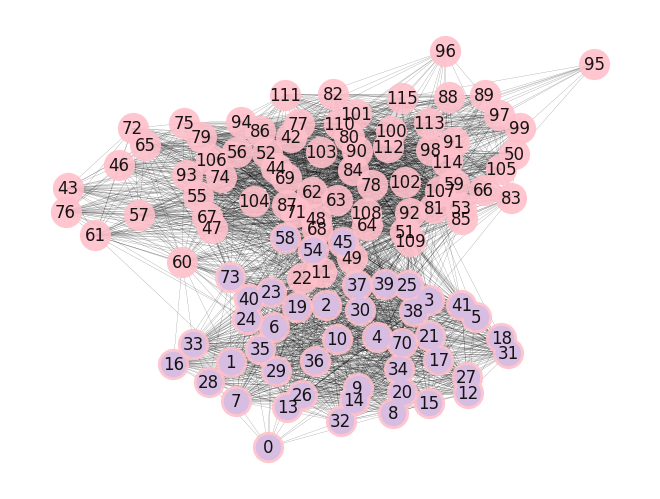

In [ ]:
node_lists_community1 = list(cmty_louvn[0])
# node_lists_community2 = list(cmty_louvn[1])
# node_lists_community3 = list(cmty_louvn[2])
pos = nx.spring_layout(g)
# pos = nx.kamada_kawai_layout(g)
nx.draw(
    g, pos, edge_color='black', width=0.1, linewidths=0.11,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in g.nodes()}
)
nx.draw_networkx_nodes(g, pos, nodelist=node_lists_community1, node_color='#D7BDE2')
# nx.draw_networkx_nodes(g, pos, nodelist=node_lists_community2, node_color='#A9CCE3')
# nx.draw_networkx_nodes(g, pos, nodelist=node_lists_community3, node_color='#A3E4D7')
plt.show()

# **Applying Label Propagation clustering algorithm on the graph and checking the number of communities**

In [ ]:
cmty_lpa = list(nx.community.label_propagation_communities(g))
print(len(cmty_lpa))

9


# **Calculating the cluster performance score using NMI and ARS**

In [ ]:
predicted_cmty_label = {}
for i in cmty_lpa[0]:
  predicted_cmty_label[i] = 0
for i in cmty_lpa[1]:
  predicted_cmty_label[i] = 1
for i in cmty_lpa[2]:
  predicted_cmty_label[i] = 2
for i in cmty_lpa[3]:
  predicted_cmty_label[i] = 3
for i in cmty_lpa[4]:
  predicted_cmty_label[i] = 4
for i in cmty_lpa[5]:
  predicted_cmty_label[i] = 5
for i in cmty_lpa[6]:
  predicted_cmty_label[i] = 6
for i in cmty_lpa[7]:
  predicted_cmty_label[i] = 7
for i in cmty_lpa[8]:
  predicted_cmty_label[i] = 8

print(predicted_cmty_label)

list_data = []
for i in predicted_cmty_label.keys():
  # print(predicted_cmty_label.get(i))
  list_data.append(predicted_cmty_label.get(i))

print(len(list_data))
label_predicted = np.array(list_data)
print(label_predicted)

predicted_keys = predicted_cmty_label.keys()
predicted_list = list(predicted_keys)
predicted_list.sort()
# print(predicted_list)

filtered_truth = [ground_truth.get(i) for i in predicted_list]
print(len(filtered_truth))
label_ground = np.array(filtered_truth)
print(label_ground)

print(normalized_mutual_info_score(label_ground, label_predicted))
print(adjusted_rand_score(label_ground, label_predicted))

{1: 0, 2: 0, 3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 11: 0, 13: 0, 16: 0, 17: 0, 18: 0, 19: 0, 21: 0, 22: 0, 23: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 70: 0, 10: 1, 35: 1, 64: 2, 65: 2, 67: 2, 69: 2, 73: 2, 42: 2, 75: 2, 44: 2, 45: 2, 76: 2, 48: 2, 49: 2, 51: 2, 52: 2, 53: 2, 54: 2, 56: 2, 72: 3, 50: 3, 43: 3, 74: 4, 46: 4, 66: 5, 71: 5, 55: 5, 57: 5, 59: 5, 63: 5, 98: 6, 100: 6, 101: 6, 103: 6, 105: 6, 77: 6, 110: 6, 79: 6, 112: 6, 113: 6, 115: 6, 84: 6, 86: 6, 91: 6, 94: 6, 102: 7, 104: 7, 106: 7, 82: 7, 83: 7, 114: 7, 85: 7, 87: 7, 89: 7, 92: 7, 93: 7, 88: 8, 99: 8, 111: 8}
91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 7 7 7 7 7 7 7 7 7 7 7 8 8 8]
91
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2

# **Plot the Clusters**

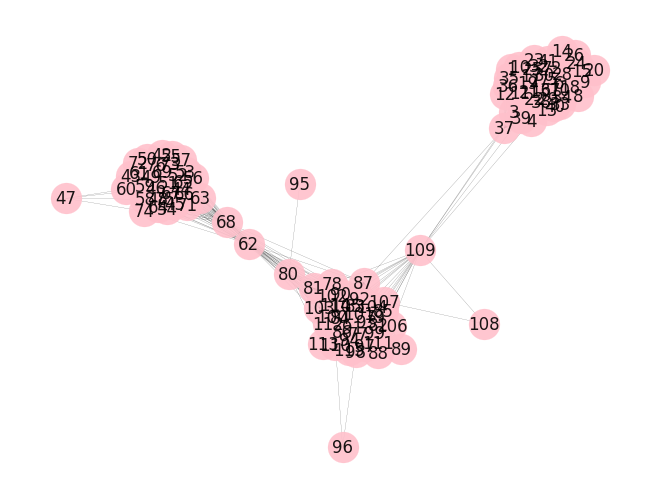

In [ ]:
pos = nx.spring_layout(g)
# pos = nx.kamada_kawai_layout(g)
# pos = nx.fruchterman_reingold_layout(g)
nx.draw(
    g, pos, edge_color='black', width=0.1, linewidths=0.11,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in g.nodes()}
)

plt.show()

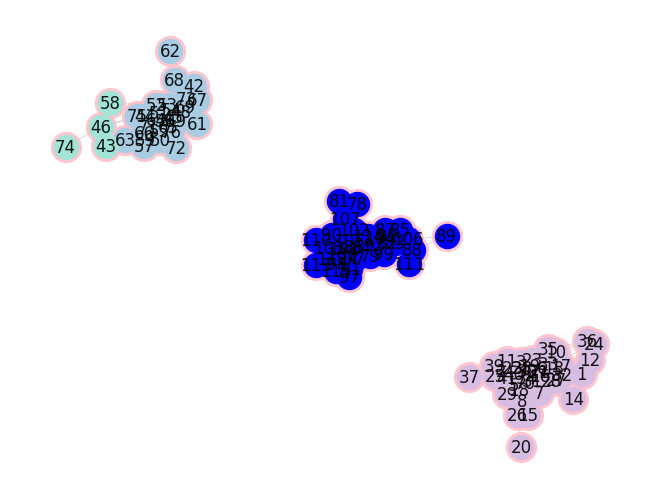

In [ ]:
node_lists_community1 = cmty_lpa[0]
node_lists_community2 = cmty_lpa[1]
node_lists_community3 = cmty_lpa[2]
node_lists_community4 = cmty_lpa[3]

pos = nx.spring_layout(g)
#pos = nx.kamada_kawai_layout(g)
nx.draw(
    g, pos, edge_color='black', width=0.1, linewidths=0.11,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in g.nodes()}
)
nx.draw_networkx_nodes(g, pos, nodelist=node_lists_community1, node_color='#D7BDE2')
nx.draw_networkx_nodes(g, pos, nodelist=node_lists_community2, node_color='#A9CCE3')
nx.draw_networkx_nodes(g, pos, nodelist=node_lists_community3, node_color='#A3E4D7')
nx.draw_networkx_nodes(g, pos, nodelist=node_lists_community4, node_color='b')

plt.show()

In [ ]:
df

,s,R,r,G,g,m,M,p,D,d,N,n,Raag
0,1,12,0,0,21,15,0,8,15,0,0,14,Bhairav
1,29,18,0,0,22,23,0,11,8,0,0,16,Bhairav
2,26,8,0,0,21,17,0,19,27,0,1,20,Bhairav
3,28,10,0,0,13,19,0,11,21,0,0,22,Bhairav
4,19,8,0,0,0,15,0,10,14,0,2,11,Bhairav
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,17,20,0,11,0,0,11,1,18,0,1,8,Todi
112,18,14,0,12,0,0,14,13,19,0,0,9,Todi
113,13,11,0,16,0,0,16,9,19,0,0,8,Todi
114,15,11,0,9,0,0,9,5,17,0,0,17,Todi


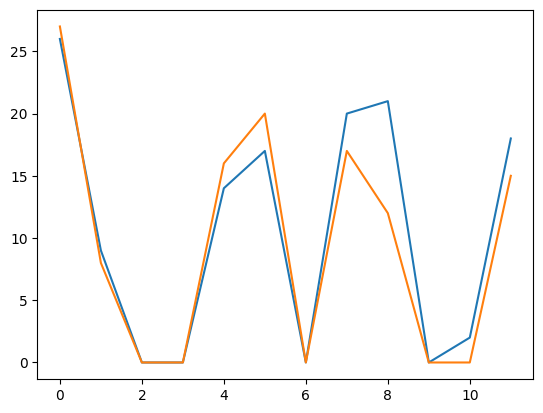

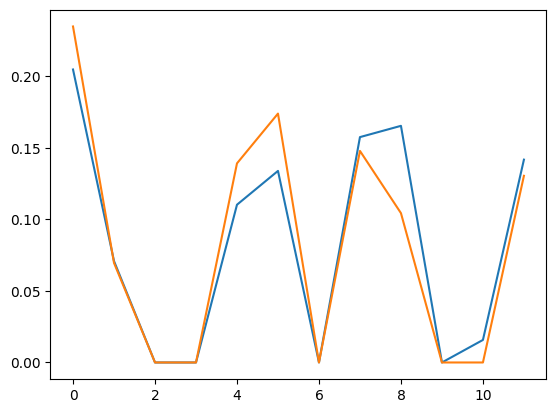

In [ ]:
def plotSongDist(dataset, raag):
  filtered_dataset = dataset.loc[(dataset['Raag']== raag)]
  #ID_removed_dataset = dataset.drop(['ID'], axis = 1)
  indices = filtered_dataset.index.values
  index1 = random.choice(indices)
  index2 = random.choice(indices)

  row1 = filtered_dataset.loc[index1]
  row2 = filtered_dataset.loc[index2]
  x = np.arange(0,12)
  y1 = row1.drop(['Raag']).values
  y2 = row2.drop(['Raag']).values
  plt.plot(x, y1)
  plt.plot(x, y2)
  plt.show()
  y1 = y1 / y1.sum()
  y2 = y2 / y2.sum()
  plt.plot(x, y1)
  plt.plot(x, y2)
  plt.show()

plotSongDist(df, 'Bhairav')

# **Cosine Similarity of two compositions**

In [ ]:
def cosine_similarity(a, b):
  sum = reduce(lambda a, b: a + b, map(lambda a, b: a * b, a, b))
  a_square = math.sqrt(reduce(lambda a, b: a + b, map(lambda a: a * a, a)))
  b_square = math.sqrt(reduce(lambda a, b: a + b, map(lambda b: b * b, b)))
  cosine_sim = sum / (a_square * b_square)
  return cosine_sim

# **Note Frequency Distribution Plot**

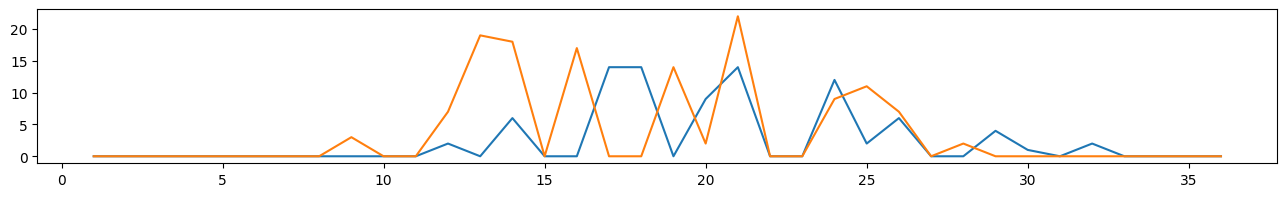

In [ ]:
bhairav_1 = [0,0,0,0,0,0,0,0,0,0,0,2,0,6,0,0,14,14,0,9,14,0,0,12,2,6,0,0,4,1,0,2,0,0,0,0]
bhairav_2 = [0,0,0,0,0,0,0,0,2,0,0,3,8,10,0,0,16,13,0,13,10,0,0,12,11,2,0,0,0,0,0,0,0,0,0,0]

poorvi_1 = [0,0,0,0,0,0,0,0,0,0,0,3,4,8,0,0,15,1,12,4,11,0,0,10,4,6,0,0,1,0,0,0,0,0,0,0]
poorvi_2 = [0,0,0,0,0,0,0,0,0,0,0,6,7,9,0,0,18,0,20,11,14,0,0,11,7,5,0,0,1,0,0,0,0,0,0,0]

todi_1 = [0,0,0,0,0,0,0,0,2,0,0,3,15,24,0,12,0,0,11,4,18,0,0,14,9,6,0,2,0,0,0,0,0,0,0,0]
todi_2 = [0,0,0,0,0,0,0,0,3,0,0,7,19,18,0,17,0,0,14,2,22,0,0,9,11,7,0,2,0,0,0,0,0,0,0,0]

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(2)

x = range(1,37)

plt.plot(x, bhairav_1)
# plt.plot(x, bhairav_2)

# plt.plot(x, poorvi_1)
# plt.plot(x, poorvi_2)

# plt.plot(x, todi_1)
plt.plot(x, todi_2)

In [ ]:
cosine_similarity(poorvi_1, todi_1)

0.7182375927744277

# **Euclidean Distance between two compositions**

In [ ]:
def euclidean_dist(a, b):
  np_a = np.array(a)/np.sum(a)
  np_b = np.array(b)/np.sum(b)
  eud_dist = math.sqrt(reduce(lambda np_a, np_b: np_a + np_b, map(lambda np_a, np_b: (np_a - np_b) ** 2, np_a, np_b)))
  return eud_dist

In [ ]:
euclidean_dist(bhairav_2, todi_2)

0.3152583034812477